# Make kerchunk mapper files for MOSAiC met files

## Overview

### What is `kerchunk`

[`kerchunk`](https://fsspec.github.io/kerchunk/) is a python library that was developed to enable efficient access to scientific data formats (HDF5, NetCDF, Grib, etc) hosted on remote servers such HTTPS, ftp and cloud object storage.  It can also be used to improve access to files on local file systems.  

>Kerchunk is a library that provides a unified way to represent a variety of chunked, compressed data formats (e.g. NetCDF/HDF5, GRIB2, TIFF, …), allowing efficient access to the data from traditional file systems or cloud object storage. It also provides a flexible way to create virtual datasets from multiple files. It does this by extracting the byte ranges, compression information and other information about the data and storing this metadata in a new, separate object. This means that you can create a virtual aggregate dataset over potentially many source files, for efficient, parallel and cloud-friendly in-situ access without having to copy or translate the originals. It is a gateway to in-the-cloud massive data processing while the data providers still insist on using legacy formats for archival storage.

_From [`kerchunk` documentation](https://fsspec.github.io/kerchunk/)_

### Why is `kerchunk` useful for MOSAiC met files?

It can take upwards of 15 minutes to load the full time series of met city tower data using `xarray`.  Yes, the `mosmet` files are big (~1.4 MB) and the whole MOSAiC time series is 270 files.  But 15 minutes is a looong time!  There has to be a better way to load and start working with this data.  Fortunately, there is `kerchunk` it!

### What this notebook covers

This notebook demonstrates how to create a virtual aggregate dataset of level 3 MOSAiC Met City tower observations at 1 minute sampling frequency.

I'm working with files on my local hard drive but there is no reason that I couldn't follow the same workflow for files stored on an ftp or https server, or in cloud object storage.

The workflow follows the kerchunk [tutorial example](https://fsspec.github.io/kerchunk/tutorial.html) to create a MultiZarr.

The first step is to create _sidecar files_ for each NetCDF file.  These are then combined into a single virtual zarr file.  All of these files are JSON files.

You can download the files using wget by uncommenting and running the cell below.

In [ ]:
#data_out = "put the directory to save the data here"
#wget -r -nH --cut-dirs=2 -o {data_out} ftp://ftp2.psl.noaa.gov/Projects/MOSAiC/tower/3_level_archive/level3.4

## Creating the kerchunked file

### Requirements

You'll need to have the following packages installed.

- `kerchunk`
- `fsspec`
- `xarray`
- `zarr`
- `cftime`
- `pqdm`
- `matplotlib`

The best way to do this is to use `mamba` or `conda`.  I recommend using `mamba` because it is more efficient.

```
mamba install kerchunk fsspec xarray zarr cftime pqdm matplotlib
```

If you don't have `mamba` installed and do not want to install it, replace `mamba` in the command above with `conda`.

If you want to use `mamba` go to [https://mamba.readthedocs.io/en/latest/](https://mamba.readthedocs.io/en/latest/) and follow the instructions to install. 

In [2]:
# From the standard python library
from pathlib import Path
import os
import ujson
import re
import warnings

# Additional packages
import fsspec  # For interfacing with file systems
from kerchunk.hdf import SingleHdf5ToZarr  # The magic sauce
from kerchunk.combine import MultiZarrToZarr  # ... more magic sauce
import xarray as xr  # For opening the kerchunked dataset
from pqdm.threads import pqdm  # To parallelize 

/home/apbarret/mambaforge/envs/mosaic_underice_sunlight/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create single file JSONs

The first step is to `kerchunk` the individual NetCDF files and write the file metadata to json files, one json file for each NetCDF file.

We first initialize a `fsspec.filesystem`.  In this case, it is the local filesystem.  But it could be a ftp or https server, or a cloud object storage such as AWS, Google Cloud, or Azure.

In [ ]:
fs = fsspec.filesystem('')
flist = fs.glob("/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/Meteorology/tower/3_level_archive/level3.4/mosmet*")

We create two helper functions. `make_json_name` generates a filename for each json sidecar file based on the date in the netcdf filename.  `gen_json` generates a json sidecar file containing byte ranges, compression, etc for a single netcdf file.  We use the `SingleHdf5toZarr` method for this because NetCDF4 files are (mostly) HDF5 files.

The `so` dictionary in `gen_json` tells `fsspec` how to open the Netcdf files and configures the file caching.  I've kept these the same as in the `kerchunk` tutorial.

Hopefully, breaking the steps into these functions makes the workflow a little clearer.

In [ ]:
def make_json_name(fname, dout='.'):
    """Returns a file path for the json sidecar file
    that contains the date for the data in the netcdf file.
    This is found from the netcdf filename.
    """
    m = re.search(r"(\d{8}).*.nc", fname)
    return Path(dout) / f"{m.groups()[0]}.json"


def gen_json(fname):
    """Generate a single json sidecar file.

    Files are written to a temporary directory.
    """
    so = dict(mode='rb', 
              anon=True, 
              default_fill_cache=False, 
              default_cache_type='first')

    with fs.open(fname, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, fname, inline_threshold=300)
        outf = make_json_name(fname, dout='temp')
        outf.parent.mkdir(parents=True, exist_ok=True)
        with fs.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

`gen_json` is now run for each NetCDF file.  I use `pqdm` to parallelize this but it doesn't seem to make a difference.  Processing 270 files takes just under a minute.

In [ ]:
%%time
result = pqdm(flist, gen_json, n_jobs=4)

### Combine the kerchunked datasets into single aggregate dataset

We could use each of the individual json to load each NetCDF file but we are most likely going to work with the data as a single time series.  We can use `kerchunk.combine.MultiZarrtoZarr` to aggregate all of the jsons into a single dataset.  That way, we can load the whole dataset at one.

:::{note.}
In fact, we will not be "loading" all of the data into memory.  Instead the data is _lazily_ loaded - the data stays on disk until needed for a computation.  Data are only moved into memory when we need to compute a value, either to write it to output or create a plot.
:::

The MOSAiC tower data have timestamps that follow CF conventions.  The time units are seconds since 00h of the day of the file (e.g `seconds since 2020-01-01 00:00:00`).  The numeric representation of the time coordinate in each file is 0:1439.  We have to tell `kerchunk` to decode the times first to avoid coordinates and data being overwritten.  This is done by setting

```
coo_map = {"time": "cf:time"}
```

In [ ]:
%%time
json_list = fs.glob('temp/*.json')

mzz = MultiZarrToZarr(json_list,
                      concat_dims=['time'],
                      coo_map = {"time": "cf:time"},
                      )

d = mzz.translate()

with fs.open('mosaic_met_tower_combined.json', 'wb') as f:
    f.write(ujson.dumps(d).encode())


## Read the kerchunked data

To read the kerchunked data, we use the `zarr` backend to xarray.  We set the `backend_args` to tell the zarr engine where the JSON reference file is stored.  This could be anywhere that is accessible via the internet but in this case it is a local file.

In [3]:
%%time
backend_args = {
    "consolidated": False, 
    "storage_options": {
        "fo": 'mosaic_met_tower_combined.json',
    }
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    big_ds = xr.open_dataset(
        "reference://", 
        engine="zarr", 
        backend_kwargs=backend_args
    )
big_ds

CPU times: user 161 ms, sys: 32.6 ms, total: 193 ms
Wall time: 193 ms


<xarray.Dataset> Size: 538MB
Dimensions:                     (time: 388800)
Coordinates:
  * time                        (time) datetime64[ns] 3MB 2019-10-15 ... 2020...
Data variables: (12/172)
    atmos_pressure_2m           (time) float64 3MB ...
    atmos_pressure_2m_qc        (time) float64 3MB ...
    atmos_pressure_mast         (time) float64 3MB ...
    atmos_pressure_mast_qc      (time) float64 3MB ...
    azimuth                     (time) float64 3MB ...
    azimuth_qc                  (time) float64 3MB ...
    ...                          ...
    wspd_w_std_mast             (time) float64 3MB ...
    wspd_w_std_mast_qc          (time) float64 3MB ...
    zenith_apparent             (time) float64 3MB ...
    zenith_apparent_qc          (time) float64 3MB ...
    zenith_true                 (time) float64 3MB ...
    zenith_true_qc              (time) float64 3MB ...
Attributes: (12/20)
    contact:                   Matthew Shupe, University of Colorado, matthew...
    conventions:               cf convention variable naming as attribute whe...
    creator_email:             michael.r.gallagher@noaa.gov; christopher.j.co...
    date_created:              Fri Feb  3 13:32:57 2023
    file_creator:              Michael R. Gallagher; Christopher J. Cox
    funding:                   Funding sources: National Science Foundation A...
    ...                        ...
    references:                Cox, C. J., M. R. Gallagher, M. D. Shupe, P. O...
    source:                    Observations made during the Multidisciplinary...
    system:                    Met City
    title:                     MOSAiC flux group data product
    version:                   4.1,  2/1/2023
    wind_sector_qc_info_flag:  Quality control flags specifically for wind se...

It takes 193 ms to _lazily_ load the file.  Loading the data using `xarray.open_mfdataset` was taking more than 15 minutes on my laptop, which is pretty powerful.

```
!lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'
CPU(s):                             20
On-line CPU(s) list:                0-19
Model name:                         13th Gen Intel(R) Core(TM) i7-1370P
Thread(s) per core:                 2
Socket(s):                          1
NUMA node(s):                       1
NUMA node0 CPU(s):                  0-19
```

Now we can start working with it.  First stop is to plot some data.

CPU times: user 207 ms, sys: 14.5 ms, total: 222 ms
Wall time: 233 ms


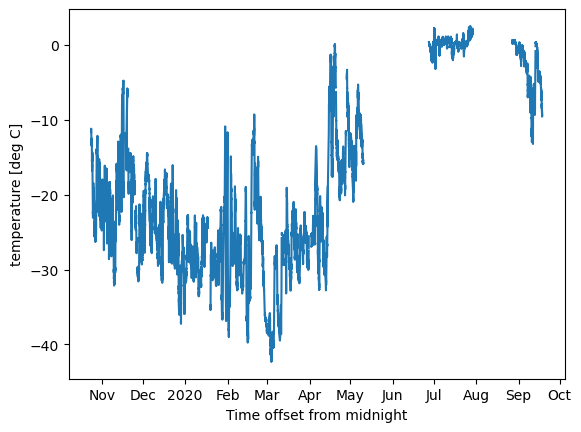

In [4]:
%%time
big_ds.temp_2m.plot()

We can resample the data to get daily mean temperature.

CPU times: user 86.7 ms, sys: 13.9 ms, total: 101 ms
Wall time: 118 ms


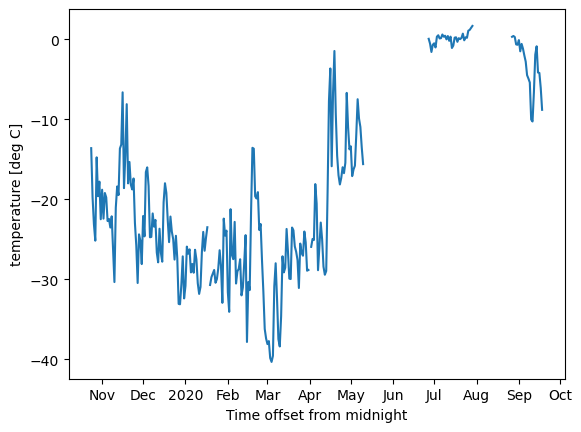

In [6]:
%%time
big_ds.temp_2m.resample(time='d').mean().plot()